In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# --- 1. Create Output Directory ---
OUTPUT_DIR = "../visuals"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- 2. Global Plotting Config ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 300 
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'


PALETTE = ['#4C72B0', '#C44E52']
COLOR_LIST = ['#4C72B0', '#C44E52']

print(f"Directory '{OUTPUT_DIR}' is ready. Setup complete.")

Directory '../visuals' is ready. Setup complete.


In [2]:
# --- Load Datasets ---
try:
    # Raw Data for original insights
    df_raw = pd.read_json("../data/IMDB_reviews.json", lines=True)
    
    # Cleaned Data for post-processing insights
    df_clean = pd.read_csv("../data/cleaned_data.csv")
    df_clean['cleaned_text'] = df_clean['cleaned_text'].astype(str)
    
    # Pre-calculate Word Count for Cleaned Data
    df_clean['word_count'] = df_clean['cleaned_text'].apply(lambda x: len(x.split()))
    
    print(f"Data Loaded successfully!")
    print(f"Raw Records: {len(df_raw)} | Cleaned Records: {len(df_clean)}")
except FileNotFoundError as e:
    print(f"Error: Ensure your data is in the '../data/' directory. {e}")

Data Loaded successfully!
Raw Records: 573913 | Cleaned Records: 49998


<Figure size 3600x2100 with 0 Axes>

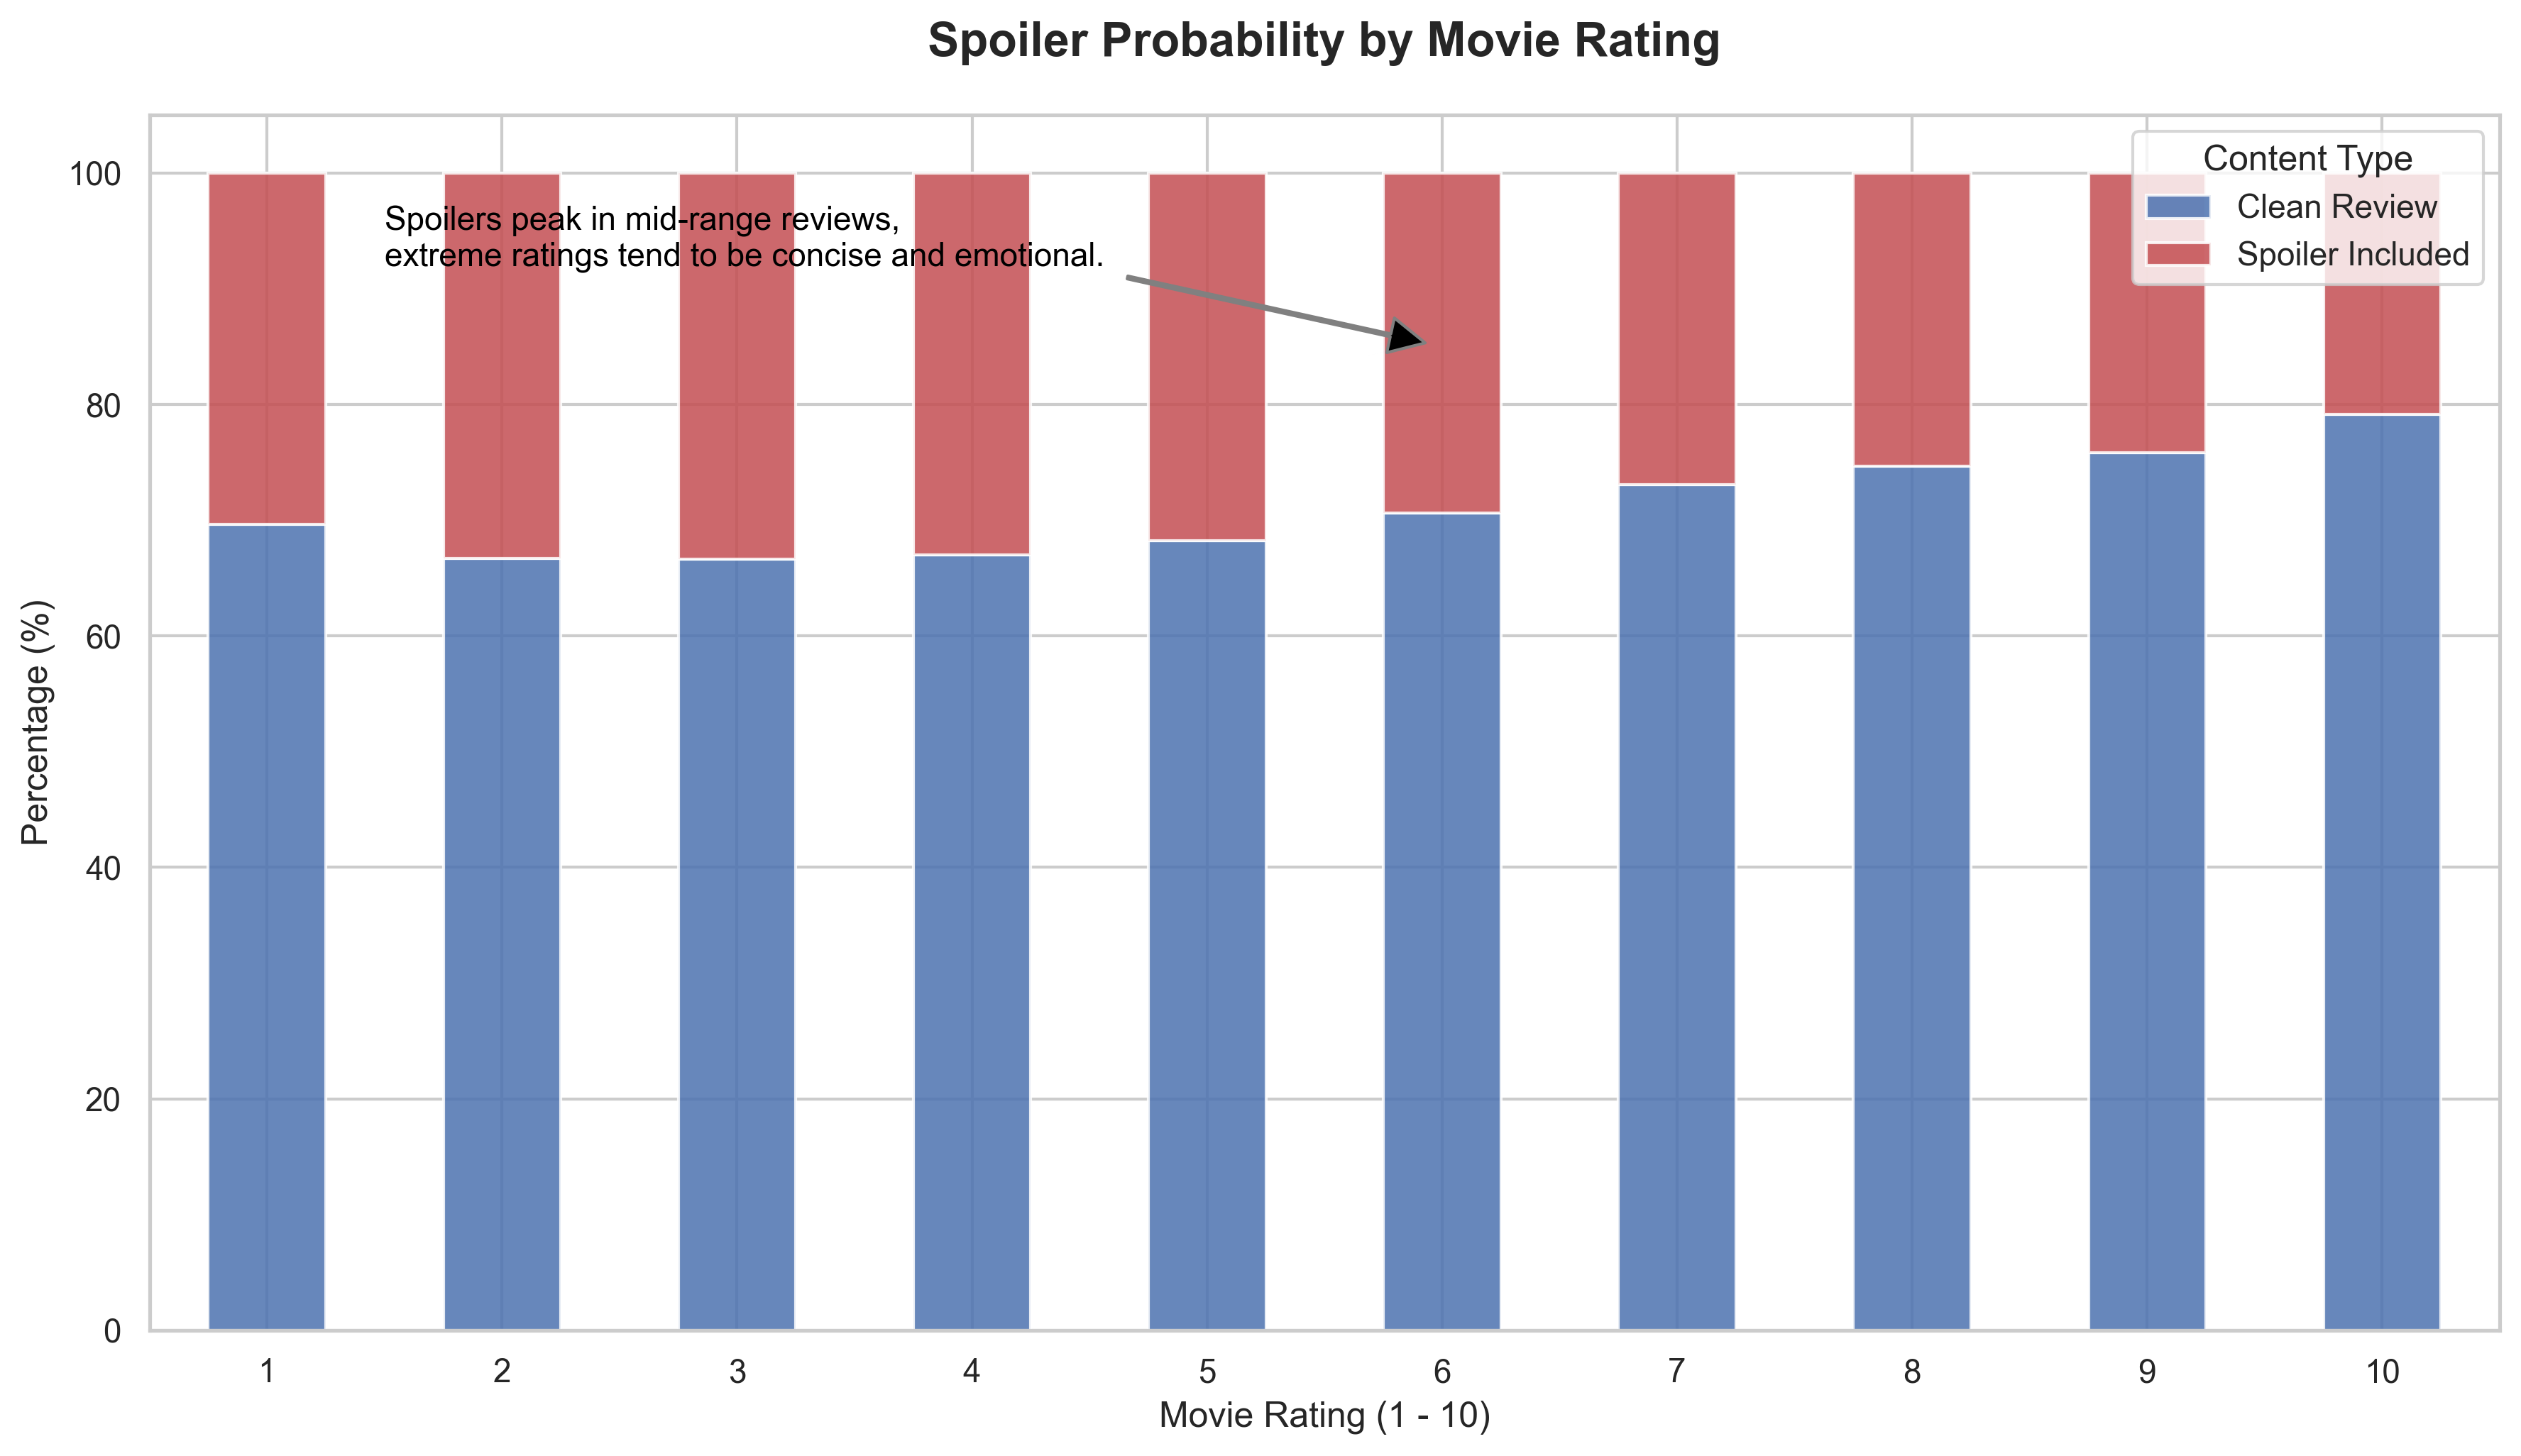

In [3]:
# --- Plot 1: Rating vs Spoiler Probability (%) ---
plt.figure(figsize=(12, 7))

# Calculate percentages for a professional probability trend
rating_stats = df_raw.groupby('rating')['is_spoiler'].value_counts(normalize=True).unstack() * 100
rating_stats = rating_stats.rename(columns={True: 'Spoiler', False: 'Clean'})

# Stacked bar chart
ax = rating_stats.plot(kind='bar', stacked=True, color=PALETTE, alpha=0.85, figsize=(12, 7))

plt.title('Spoiler Probability by Movie Rating', pad=20)
plt.xlabel('Movie Rating (1 - 10)', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Content Type', labels=['Clean Review', 'Spoiler Included'], loc='upper right')

# Trend Annotation
plt.annotate('Spoilers peak in mid-range reviews,\nextreme ratings tend to be concise and emotional.', 
             xy=(5, 85), xytext=(0.5, 92),
             arrowprops=dict(facecolor='black', edgecolor='grey', shrink=0.05, width=1),
             fontsize=11,color='black')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/01_rating_vs_spoiler.png")
plt.show()

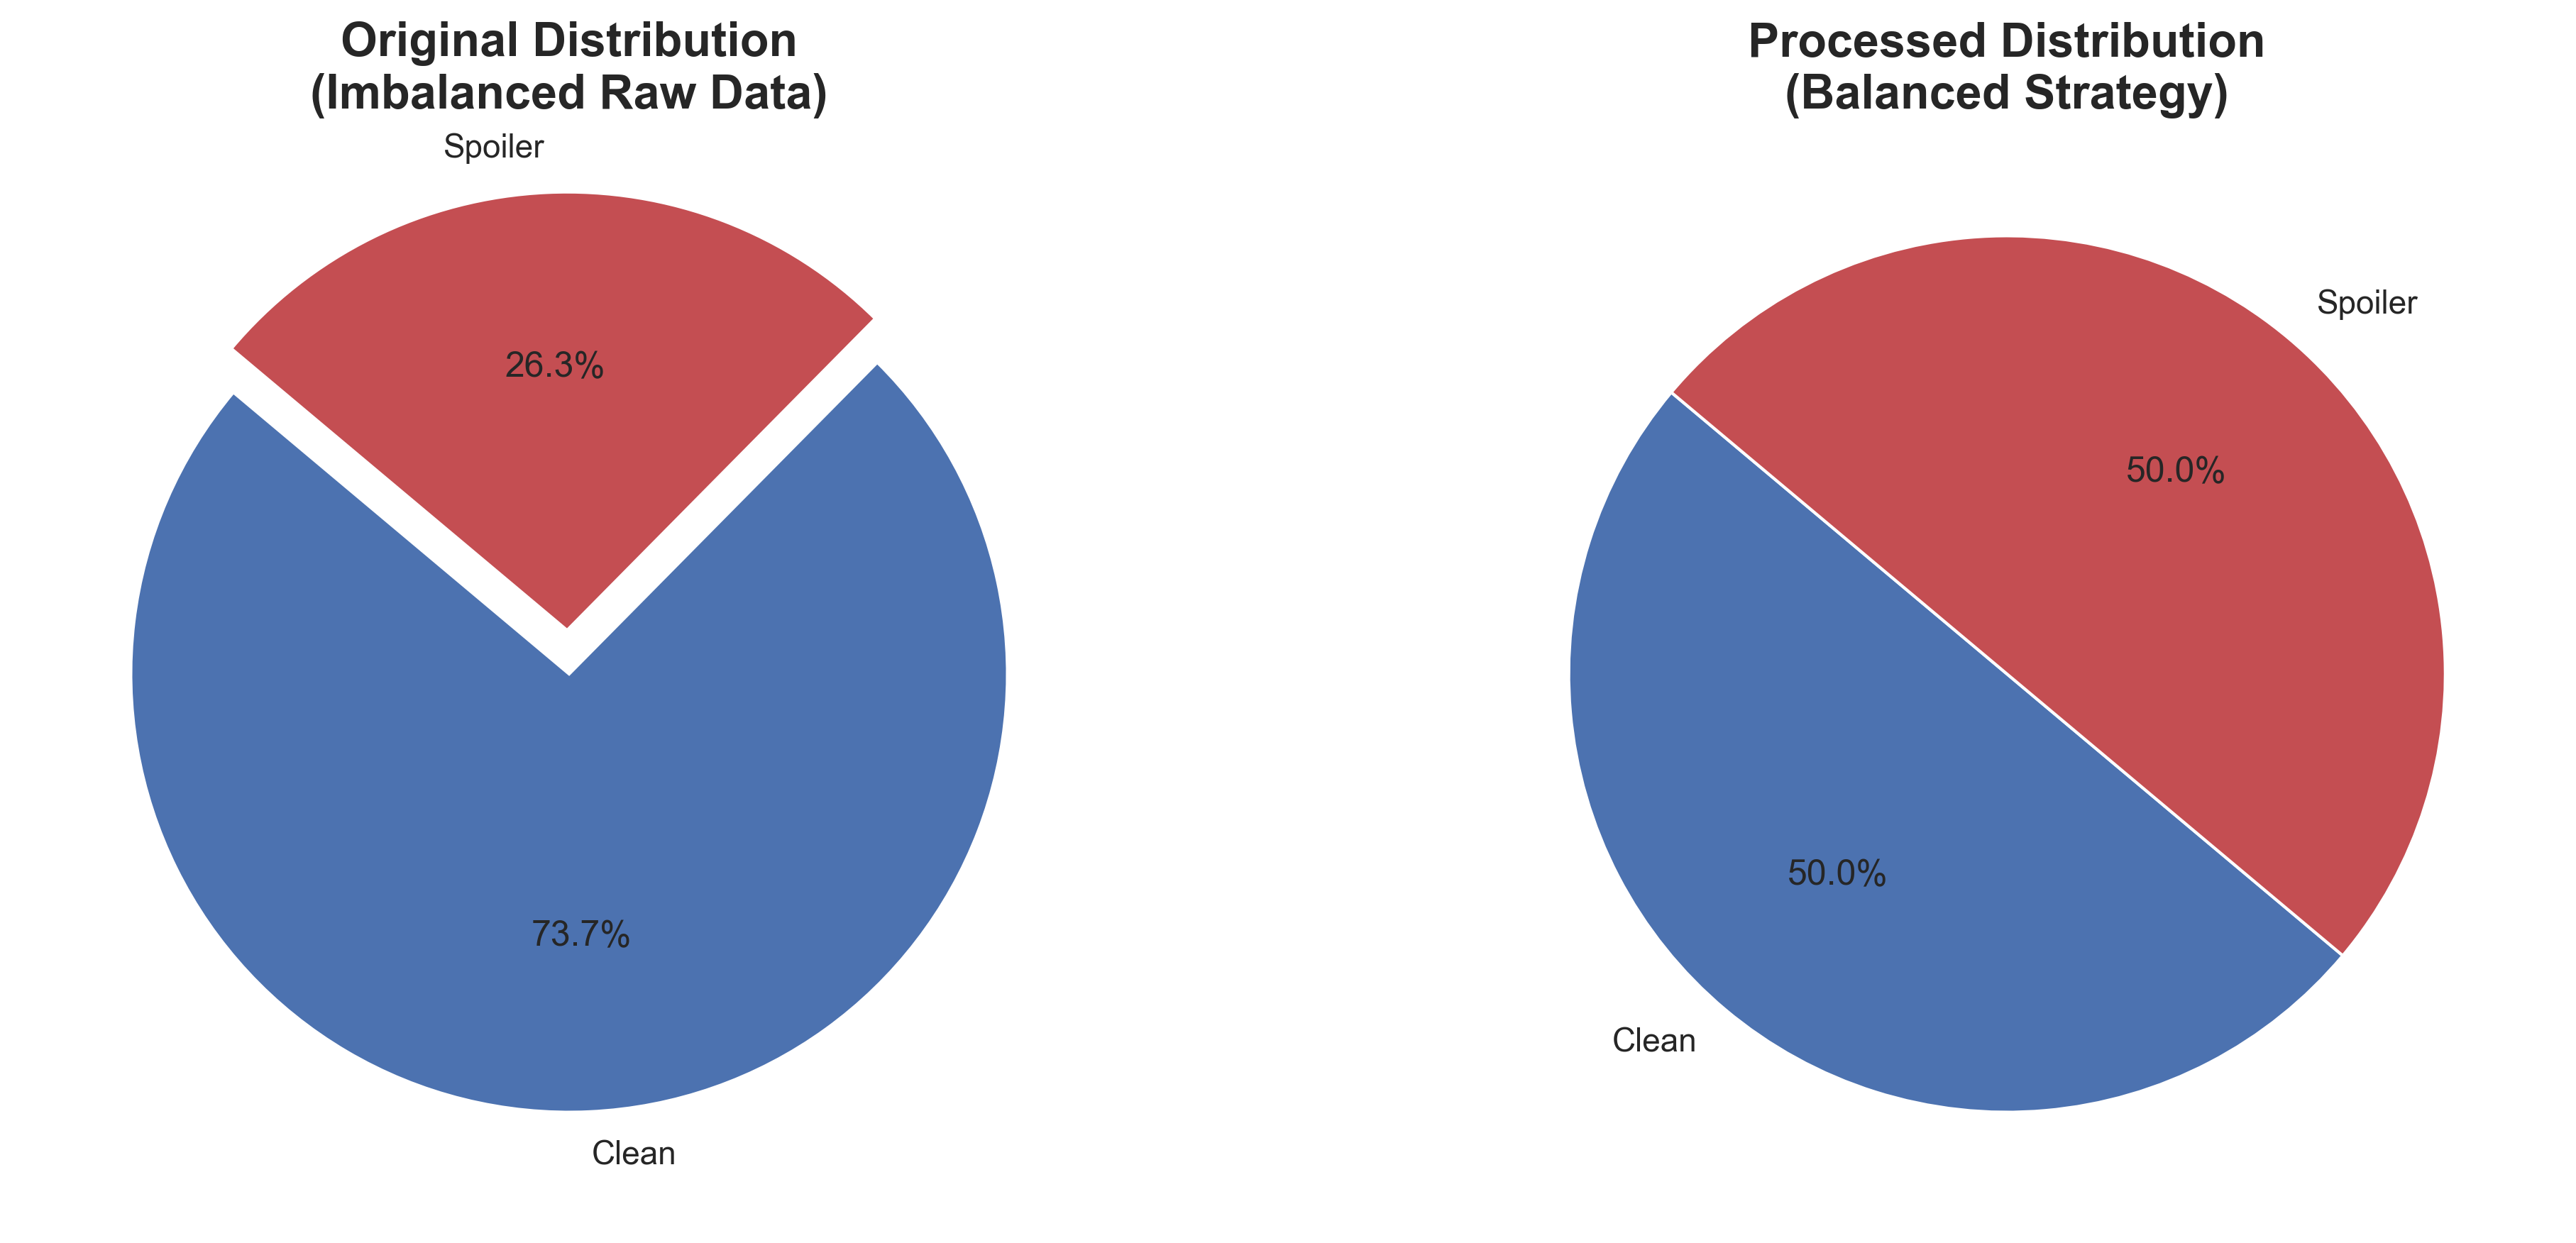

In [4]:
# --- Plot 2: Class Balance (Original vs. Balanced) ---
raw_counts = df_raw['is_spoiler'].value_counts()
balanced_counts = df_clean['label'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Original Distribution (Pie)
ax1.pie(raw_counts, labels=['Clean', 'Spoiler'], autopct='%1.1f%%', 
        colors=PALETTE, startangle=140, explode=(0, 0.1))
ax1.set_title('Original Distribution\n(Imbalanced Raw Data)')

# Balanced Distribution (Pie)
ax2.pie(balanced_counts, labels=['Clean', 'Spoiler'], autopct='%1.1f%%', 
        colors=PALETTE, startangle=140)
ax2.set_title('Processed Distribution\n(Balanced Strategy)')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/02_class_balance_strategy.png")
plt.show()

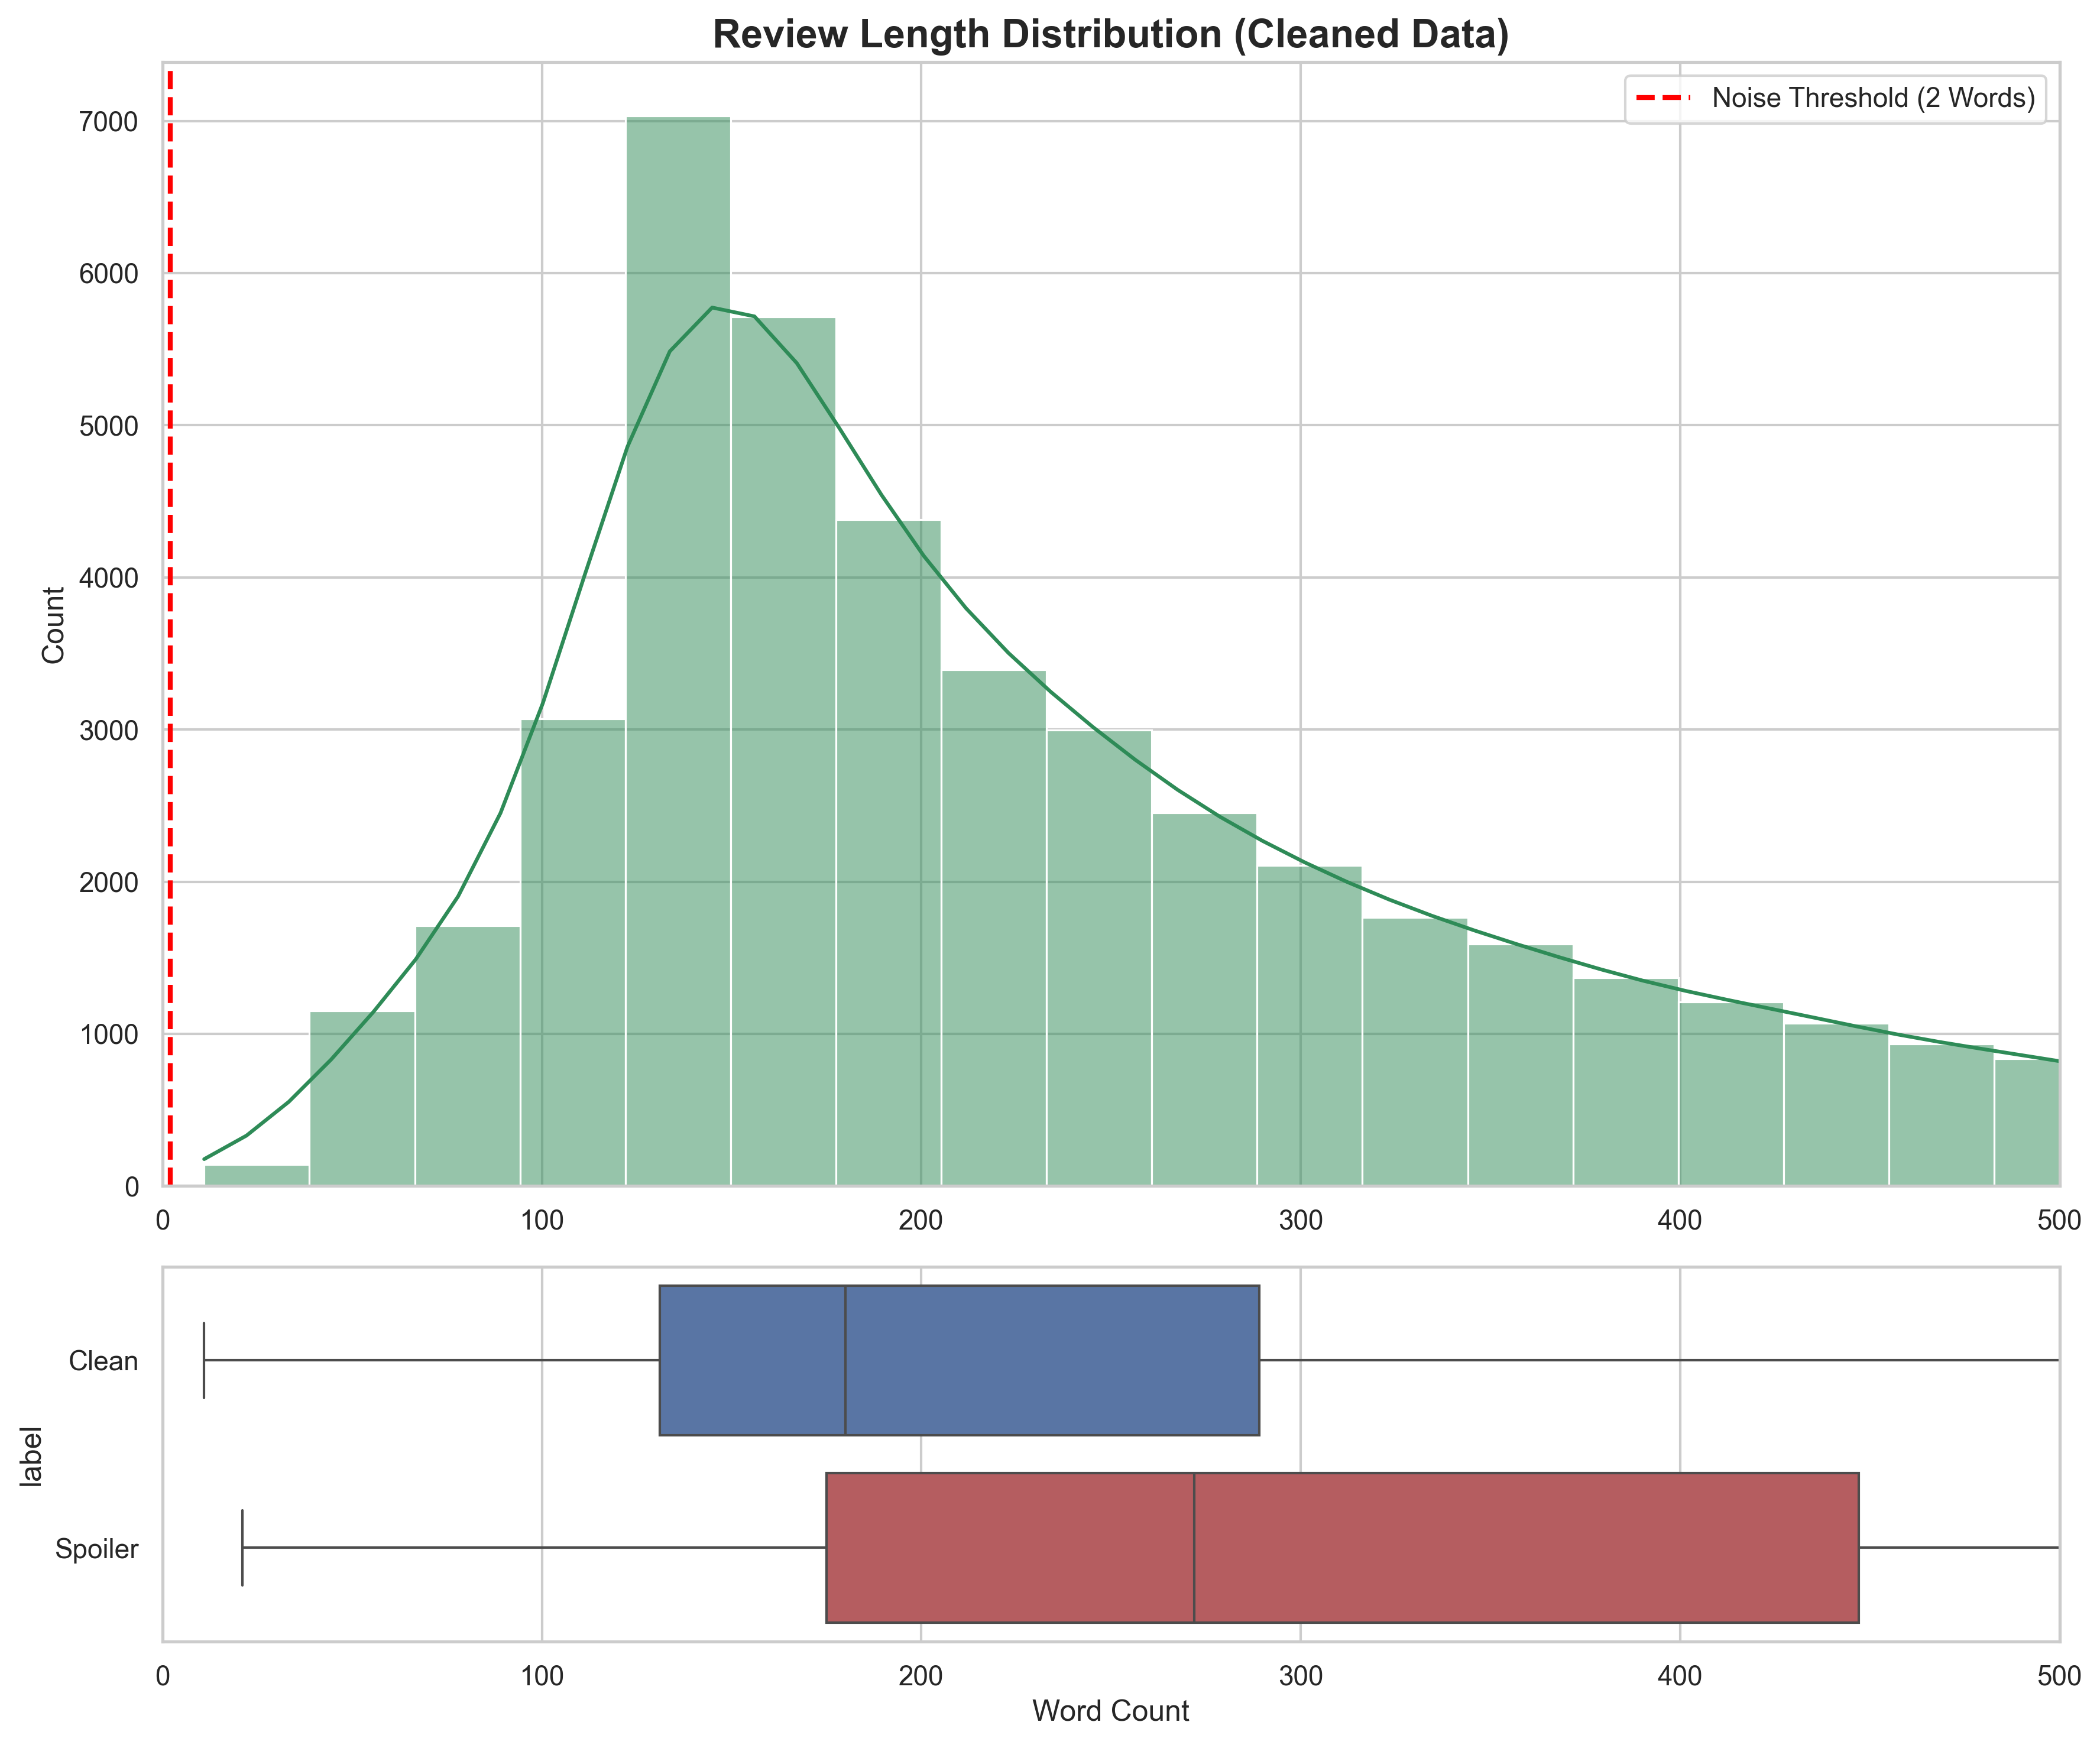

In [5]:
# --- Plot 3: Review Length Distribution ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]})

# Histogram with KDE
sns.histplot(df_clean['word_count'], bins=80, kde=True, color='#2e8b57', ax=ax1)
# Using x=2 based on your preprocessing logic to ensure consistency
ax1.axvline(x=2, color='red', linestyle='--', linewidth=2, label='Noise Threshold (2 Words)')
ax1.set_title('Review Length Distribution (Cleaned Data)')
ax1.set_xlabel('')
ax1.set_xlim(0, 500)
ax1.legend()

# Boxplot by Class 
sns.boxplot(x='word_count', y='label', data=df_clean, orient='h', 
            palette=PALETTE, hue='label', legend=False, ax=ax2)


ax2.set_yticks([0, 1]) 
ax2.set_yticklabels(['Clean', 'Spoiler'])
ax2.set_xlabel('Word Count')
ax2.set_xlim(0, 500)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/03_word_count_analysis.png")
plt.show()

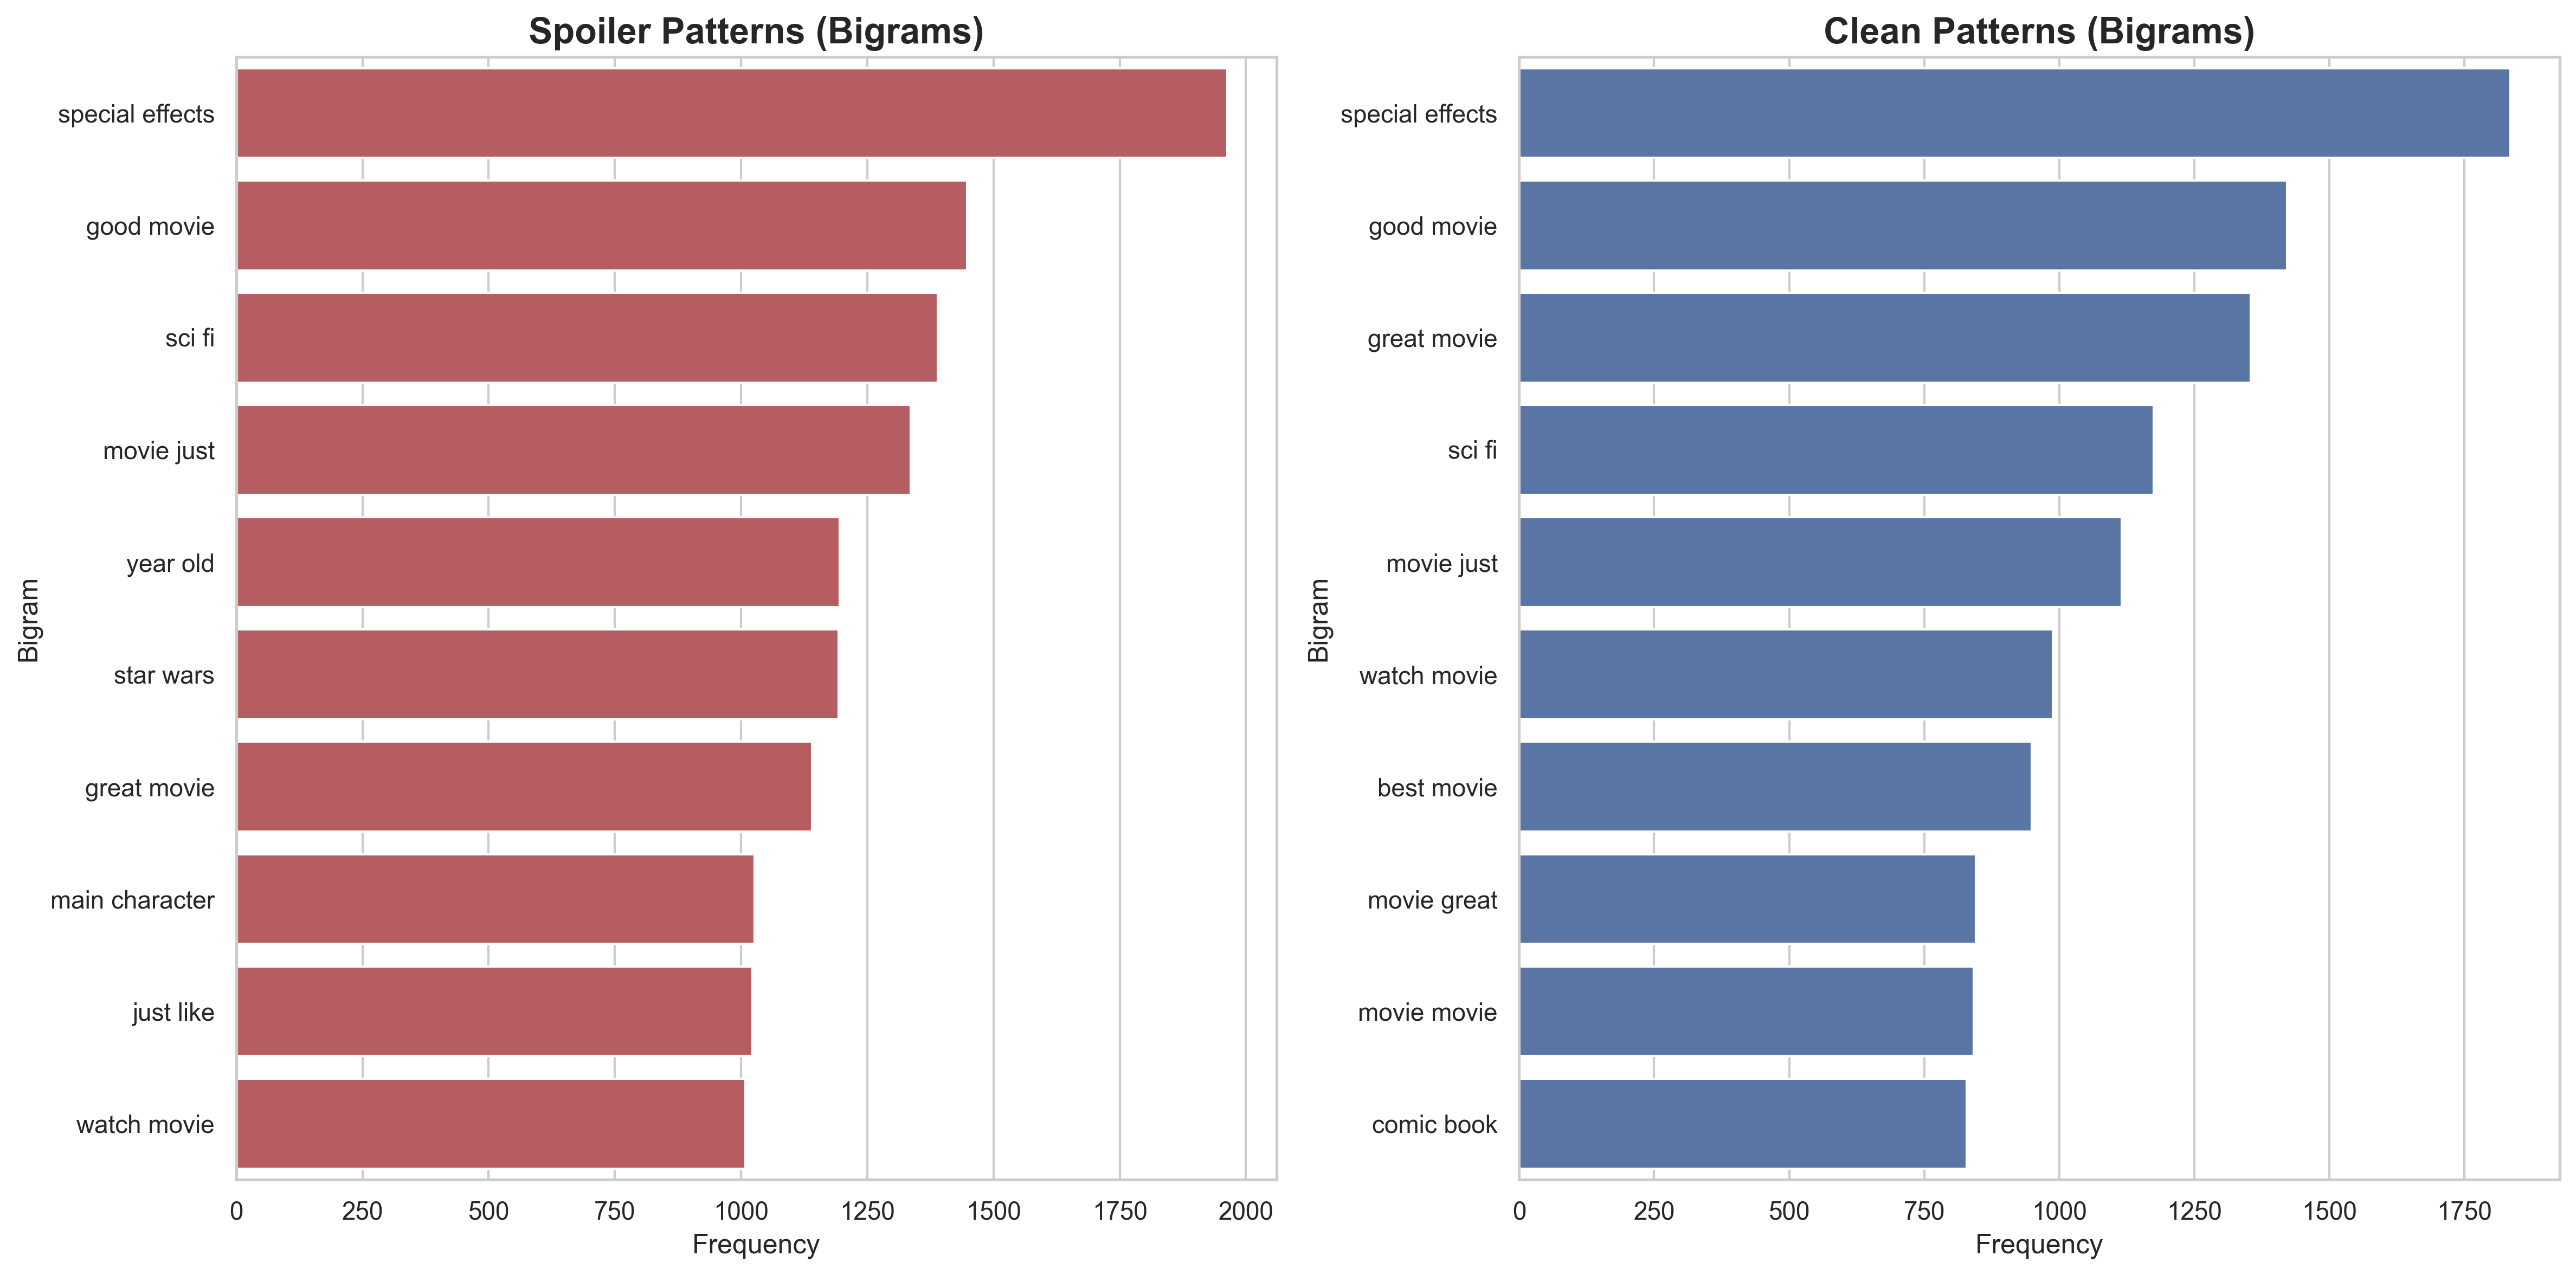

In [6]:
# --- Plot 4: Top Bigrams per Class ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

def get_top_bigrams(text_series, n=10):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text_series)
    bag_of_words = vec.transform(text_series)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(words_freq[:n], columns=['Bigram', 'Frequency'])

# Spoiler Bigrams (Red)
spoiler_bg = get_top_bigrams(df_clean[df_clean['label'] == 1]['cleaned_text'])
sns.barplot(x='Frequency', y='Bigram', data=spoiler_bg, ax=ax1, color='#C44E52')
ax1.set_title('Spoiler Patterns (Bigrams)')

# Clean Bigrams (Blue)
clean_bg = get_top_bigrams(df_clean[df_clean['label'] == 0]['cleaned_text'])
sns.barplot(x='Frequency', y='Bigram', data=clean_bg, ax=ax2, color='#4C72B0')
ax2.set_title('Clean Patterns (Bigrams)')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/04_bigram_patterns.png")
plt.show()

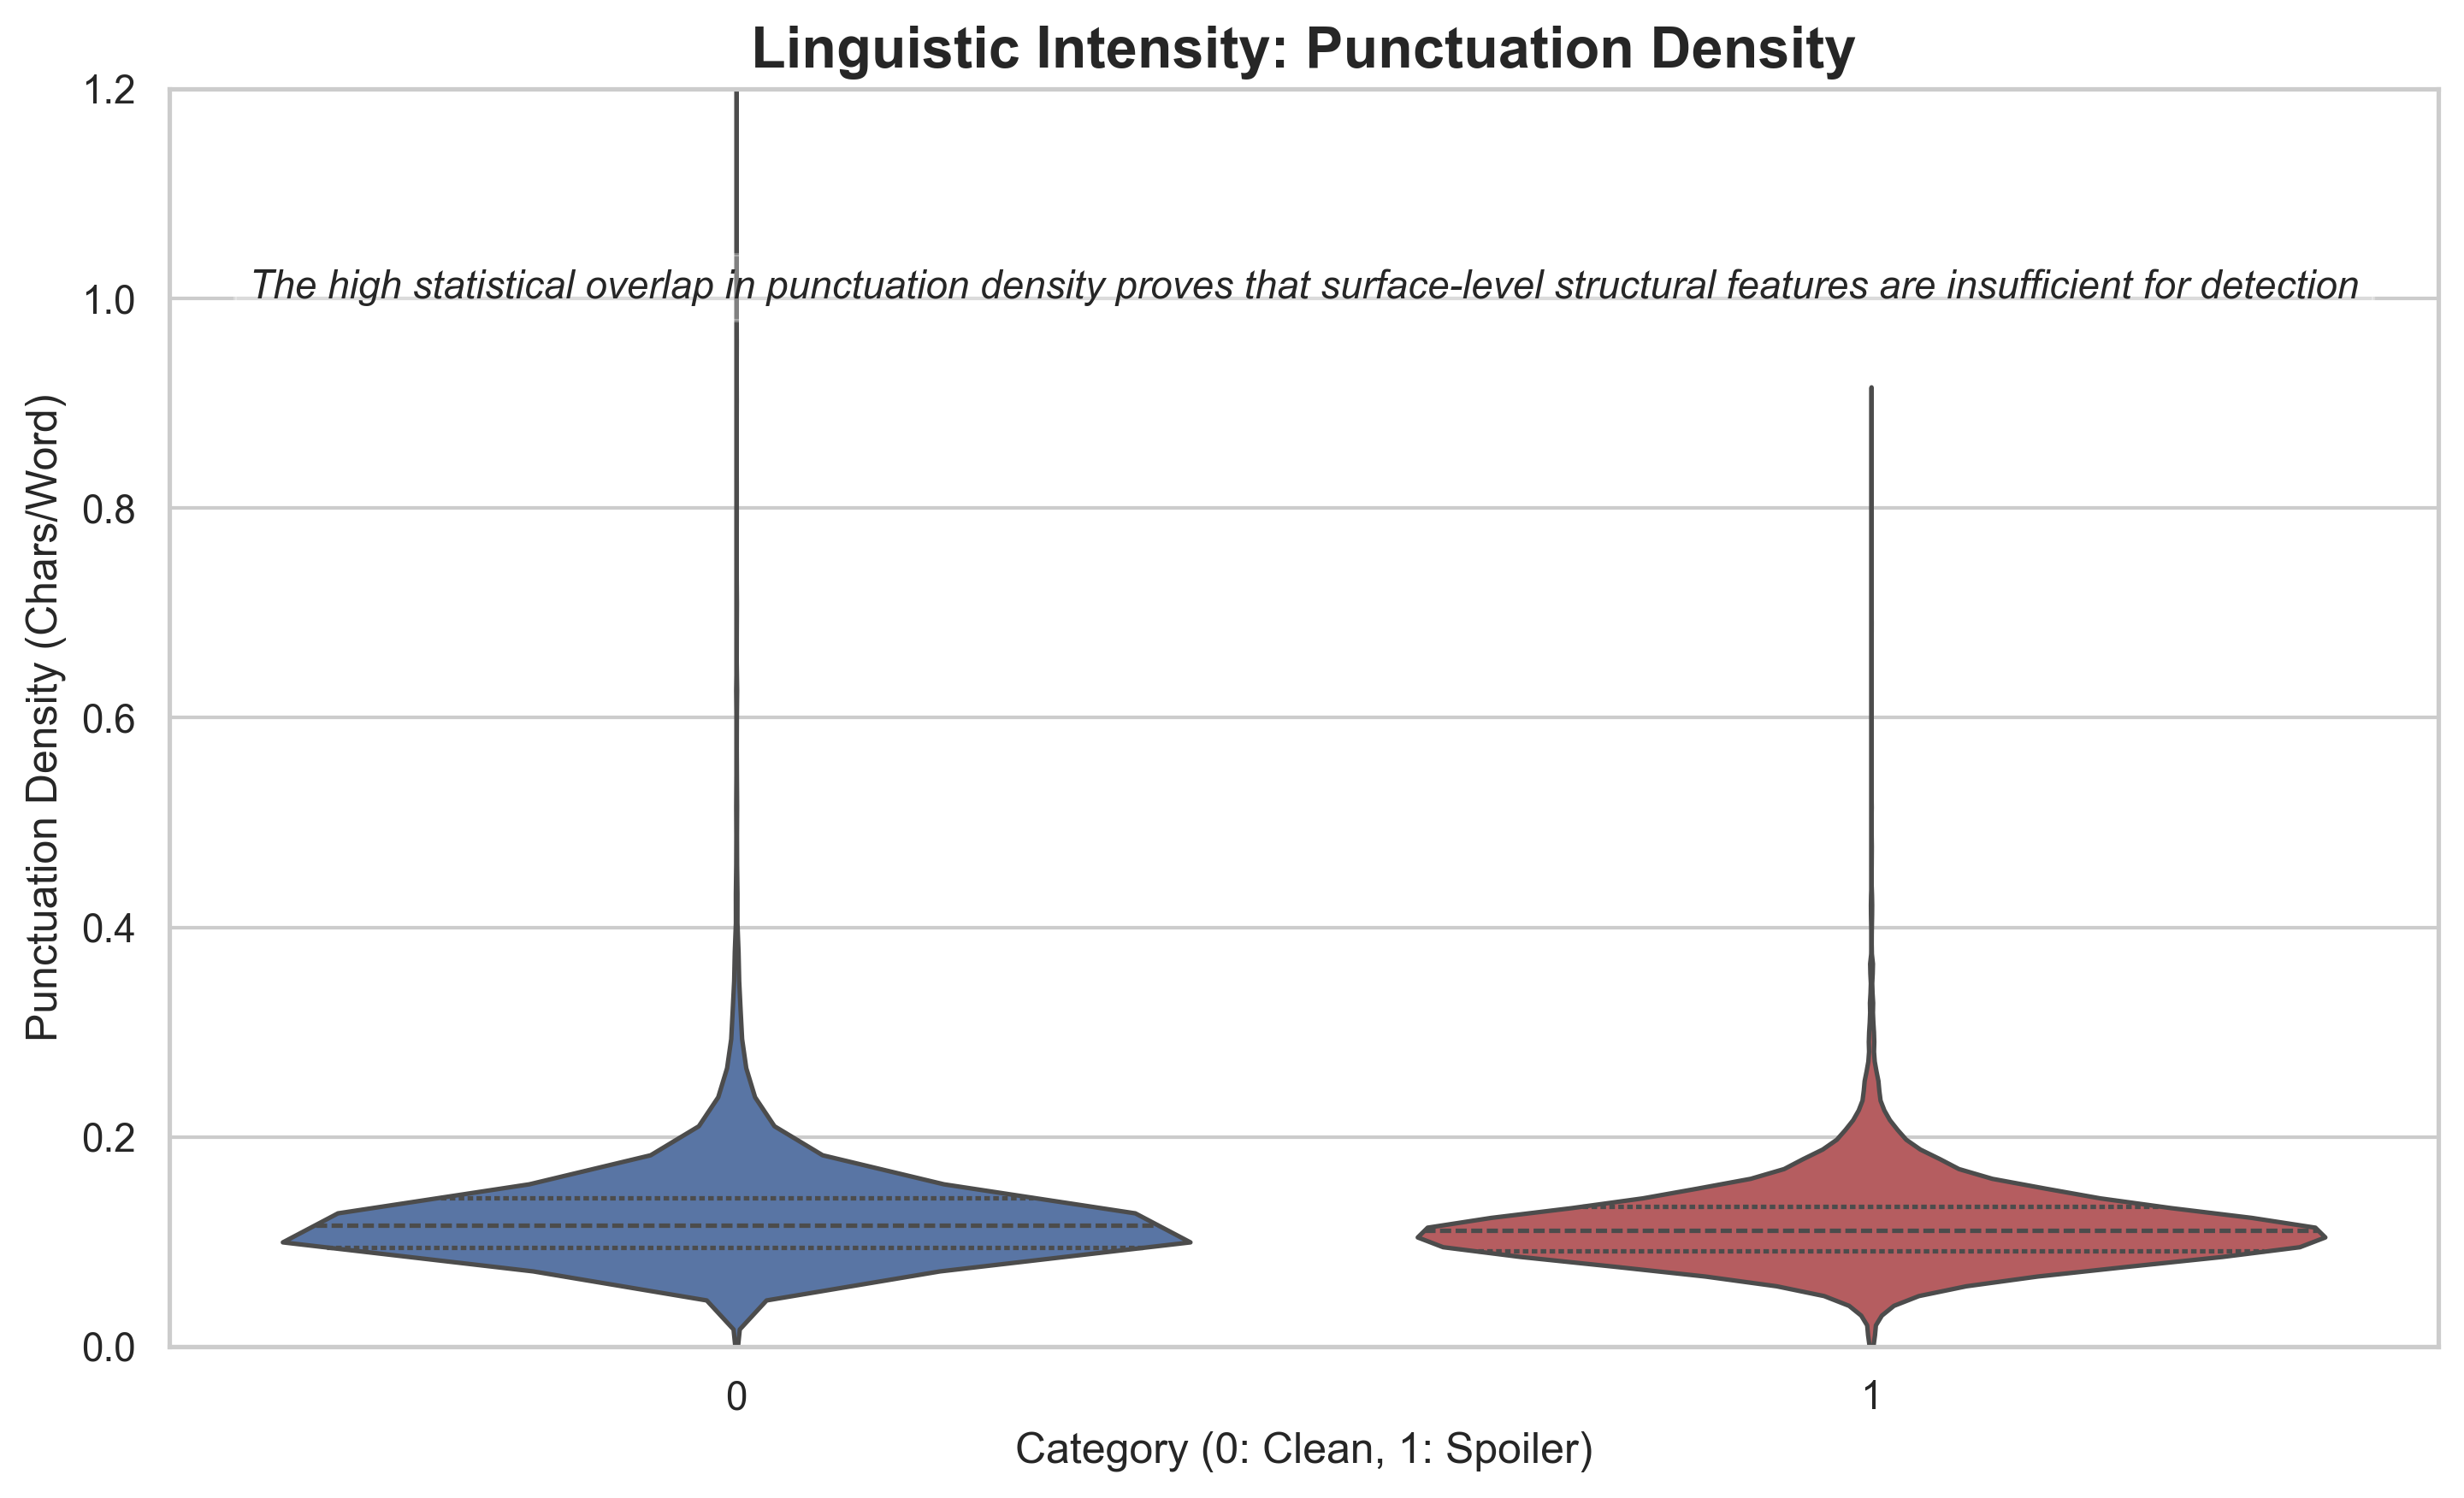

In [7]:
# --- Plot 5: Punctuation Density (Violin Plot) ---
def count_punct_density(text):
    # Ratio of critical punctuation per word
    return sum([1 for char in text if char in '!?.,']) / len(text.split()) if len(text.split()) > 0 else 0

df_clean['punct_density'] = df_clean['cleaned_text'].apply(count_punct_density)

plt.figure(figsize=(10, 6))
sns.violinplot(x='label', y='punct_density', data=df_clean, 
               palette=PALETTE, hue='label', legend=False, inner="quart")

plt.title('Linguistic Intensity: Punctuation Density')
plt.xlabel('Category (0: Clean, 1: Spoiler)')
plt.ylabel('Punctuation Density (Chars/Word)')
plt.ylim(0, 1.2)

plt.text(0.5, 1.0, "The high statistical overlap in punctuation density proves that surface-level structural features are insufficient for detection", 
         fontsize=11, ha='center', style='italic', bbox=dict(facecolor='white', alpha=0.3))

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/05_punctuation_density.png")
plt.show()